In [10]:
# 0.  Imports & Logging
import logging
from pathlib import Path
import pandas as pd
import spacy
from rapidfuzz import fuzz
from collections import Counter
from IPython.display import display
import matplotlib.pyplot as plt
from config import OUTPUT_FOLDER

In [11]:
# %% 
# 9.  Summary by noun_gender × adjective_gender (with percentages)
# 1.  Configuration
CSV_IN       = Path(OUTPUT_FOLDER) / "sentences_final.csv"


# %% 
# 2.  Preflight & Load
if not CSV_IN.exists():
    logger.error(f"Input file not found: {CSV_IN}")
    raise FileNotFoundError(f"{CSV_IN} does not exist")
logger.info(f"Reading input CSV from {CSV_IN}")
df = pd.read_csv(CSV_IN, encoding=ENCODING, on_bad_lines="warn")



2025-04-28 10:22:16 INFO     sentence_cleaner: Reading input CSV from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/phase_02/output/sentences_final.csv


In [12]:
# ---------------------------------------------------------------------
# 7.  Leakage summary
# ---------------------------------------------------------------------
pct_multi = (df['total_in_lists'] > 1).mean() * 100
# ---------------------------------------------------------------------
# 8.  Print example sentences with both male & female adjectives
# ---------------------------------------------------------------------
# Print to console (and log)
print(f"% sentences with more than one adjective: {pct_multi:.2f}%")
logger.info("Leakage summary — >1 count: %.2f%%;",
            pct_multi)

2025-04-28 10:22:17 INFO     sentence_cleaner: Leakage summary — >1 count: 36.36%;


% sentences with more than one adjective: 36.36%


/var/folders/v_/ypb5b1nx079dj_hcjyz0t47c0000gn/T/ipykernel_61298/3840618518.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda sub: (sub['total_in_lists'] > 1).mean() * 100)


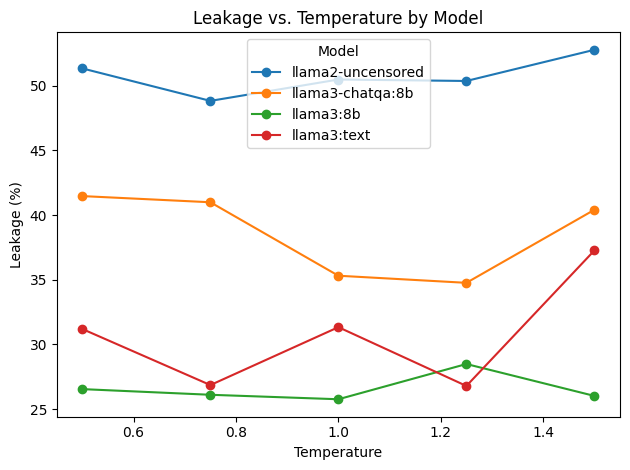

In [13]:
# Aggregate leakage by model × temperature
agg_model_temp = (
    df
    .groupby(['model', 'temperature'])
    .apply(lambda sub: (sub['total_in_lists'] > 1).mean() * 100)
    .reset_index(name='pct_multi')
)

# Plot each model in its own color
plt.figure()
for model in agg_model_temp['model'].unique():
    subset = agg_model_temp[agg_model_temp['model'] == model]
    plt.plot(
        subset['temperature'],
        subset['pct_multi'],
        marker='o',
        label=model
    )

plt.xlabel('Temperature')
plt.ylabel('Leakage (%)')
plt.title('Leakage vs. Temperature by Model')
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [17]:
print(df)

                word                                           sentence  \
0              lamme                de lamme man was een vrolijke kerel   
1         impopulair   de impopulaire jongen heeft het niet gemakkelijk   
2         overmoedig                   overmoedig is de man die je bent   
3      vooraanstaand  hij was vooraanstaand in het leven van een man...   
4        gewetenloos  deze gewetenloze man mannen jongen jongens hee...   
...              ...                                                ...   
15162         hitsig  het hitsige uitstralen van deze meisjes maakt ...   
15163     glamoureus  de glamour uitstraling van deze dame zorgt erv...   
15164     bloedmooie  bloedmooie meisjes hebben een eigen unieke sfe...   
15165       exotisch  exotische dames tonen altijd een speciale aanb...   
15166       spichtig  een spichtig meisje is altijd mooi te vinden m...   

                   model noun_gender adjective_gender  temperature  \
0            llama3:text     


Leakage by prompt structure:
              pct_multi
prompt_type           
F→F              37.12
F→M              35.29
M→F              36.04
M→M              36.98


/var/folders/v_/ypb5b1nx079dj_hcjyz0t47c0000gn/T/ipykernel_61298/3785049157.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda sub: pd.Series({


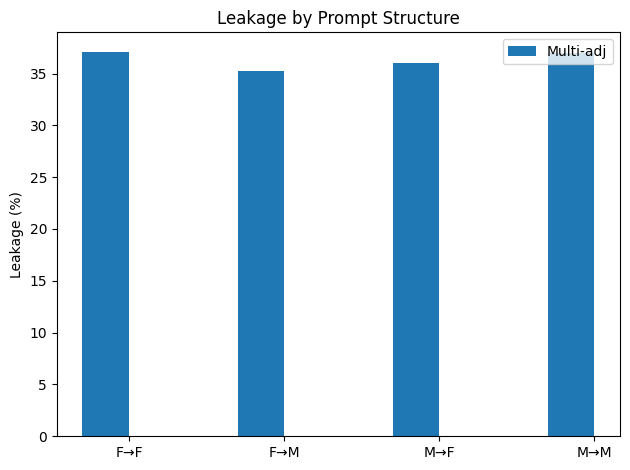

In [14]:
# ——— 1. derive prompt_type ———
# Map “male”→“M”, “female”→“F” and build e.g. “M→F”, “F→M”, etc.
gender_map = {"male":"M", "female":"F"}
df["prompt_type"] = (
    df["adjective_gender"].map(gender_map)
  + "→"
  + df["noun_gender"].map(gender_map)
)

# ——— 3. Prompt‑structure interaction ———
pt = (
    df
    .groupby("prompt_type")
    .apply(lambda sub: pd.Series({
        "pct_multi": (sub["total_in_lists"]>1).mean()*100,
    
    }))
    .round(2)
)
print("\nLeakage by prompt structure:\n", pt)

import numpy as np
# grouped bar chart
labels = pt.index.tolist()
x = np.arange(len(labels))
plt.bar(x-0.15, pt["pct_multi"], width=0.3, label="Multi‑adj")
plt.xticks(x, labels); plt.ylabel("Leakage (%)")
plt.title("Leakage by Prompt Structure")
plt.legend(); plt.tight_layout()
plt.show()


             pct_multi  pct_co
prompt_type                   
F→F              37.12   11.62
F→M              35.29   10.77
M→F              36.04   10.62
M→M              36.98   10.21


/var/folders/v_/ypb5b1nx079dj_hcjyz0t47c0000gn/T/ipykernel_61298/3107383801.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pt = df.groupby('prompt_type').apply(lambda sub: pd.Series({


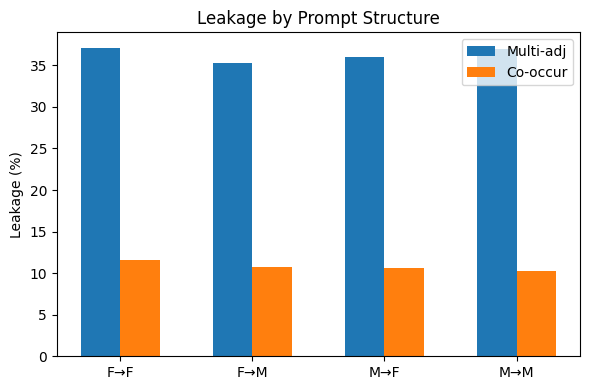

In [15]:
# leakage by prompt_type
pt = df.groupby('prompt_type').apply(lambda sub: pd.Series({
    'pct_multi': (sub['total_in_lists']>1).mean()*100,
    'pct_co':    ((sub['male_count']>0)&(sub['female_count']>0)).mean()*100
})).round(2)

print(pt)

import numpy as np

labels = pt.index.tolist()
multi = pt['pct_multi'].values
co    = pt['pct_co'].values
x = np.arange(len(labels))

plt.figure(figsize=(6,4))
plt.bar(x-0.15, multi, width=0.3, label='Multi‑adj')
plt.bar(x+0.15, co,    width=0.3, label='Co‑occur')
plt.xticks(x, labels)
plt.ylabel('Leakage (%)')
plt.title('Leakage by Prompt Structure')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# 1. Count each category
count_MM = len(df[(df['noun_gender']=='male') & (df['adjective_gender']=='male')])
count_FF = len(df[(df['noun_gender']=='female') & (df['adjective_gender']=='female')])
count_MF = len(df[(df['noun_gender']=='male') & (df['adjective_gender']=='female')])
count_FM = len(df[(df['noun_gender']=='female') & (df['adjective_gender']=='male')])

# 2. Totals
total_S = count_MM + count_FF
total_C = count_MF + count_FM
grand_total = len(df)

# 3. Percentages (relative to each half of the dataset)
pct_MM = count_MM / total_S * 100
pct_FF = count_FF / total_S * 100
pct_MF = count_MF / total_C * 100
pct_FM = count_FM / total_C * 100

# 4. Build summary table
summary = pd.DataFrame({
    '': [
        'Consistent with gender stereotype (S)',
        'Contradictory to gender stereotype (S)',
        'Total'
    ],
    '#MM': [f"{count_MM} ({pct_MM:.1f}%)", f"{count_MF} ({pct_MF:.1f}%)", ''],
    '#FF': [f"{count_FF} ({pct_FF:.1f}%)", f"{count_FM} ({pct_FM:.1f}%)", ''],
    '#Total': [f"{total_S} ({total_S/grand_total*100:.1f}%)",
               f"{total_C} ({total_C/grand_total*100:.1f}%)",
               f"{grand_total}"]
})

# 5. Display the table
print("Table 2: Labeling details with size & distribution", summary)

Table 2: Labeling details with size & distribution                                                     #MM           #FF  \
0   Consistent with gender stereotype (S)  3789 (49.9%)  3804 (50.1%)   
1  Contradictory to gender stereotype (S)  3789 (50.0%)  3785 (50.0%)   
2                                   Total                               

         #Total  
0  7593 (50.1%)  
1  7574 (49.9%)  
2         15167  
